# Kuinka tehdä täydellinen ennustemalli sähkön pörssihinnan kehityksestä?

## Kirjastojen tuonti

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Ladataan päiväkohtainen aineisto sisään

https://www.nordpoolgroup.com/historical-market-data/

In [2]:
data = pd.read_excel("elspot price 2013 2022.xlsx") 
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.tail()

,FI
Date,
2022-01-05,121.66
2022-01-06,169.68
2022-01-07,166.34
2022-01-08,159.96
2022-01-09,145.82


## Valitaan oikea ajanjakso, viikkokohtainen otos

In [3]:
data = data['2013-01-01':'2022-01-09'].resample('W').sum()
data.tail()

,FI
Date,
2021-12-12,2024.81
2021-12-19,900.95
2021-12-26,1631.22
2022-01-02,722.58
2022-01-09,968.03


## Aikasarjan vaihtelua aiheuttavien komponenttien erottelu
### Observed=alkuperäinen aikasarja, Trend=trendi, Seasonal=kausivaihtelu,
### Residual=muu kuin trendiin ja kausivaihteluun liittyvä vaihtelu

### Tuloksena saan neljä kuviota:
### alkuperäinen aikasarja
### aikasarjasta erotettu trendi
### aikasarjan kausivaihtelu
### aikasarjan jäljelle jäänyt osa trendin ja kausivaihtelun poistamisen jälkeen.

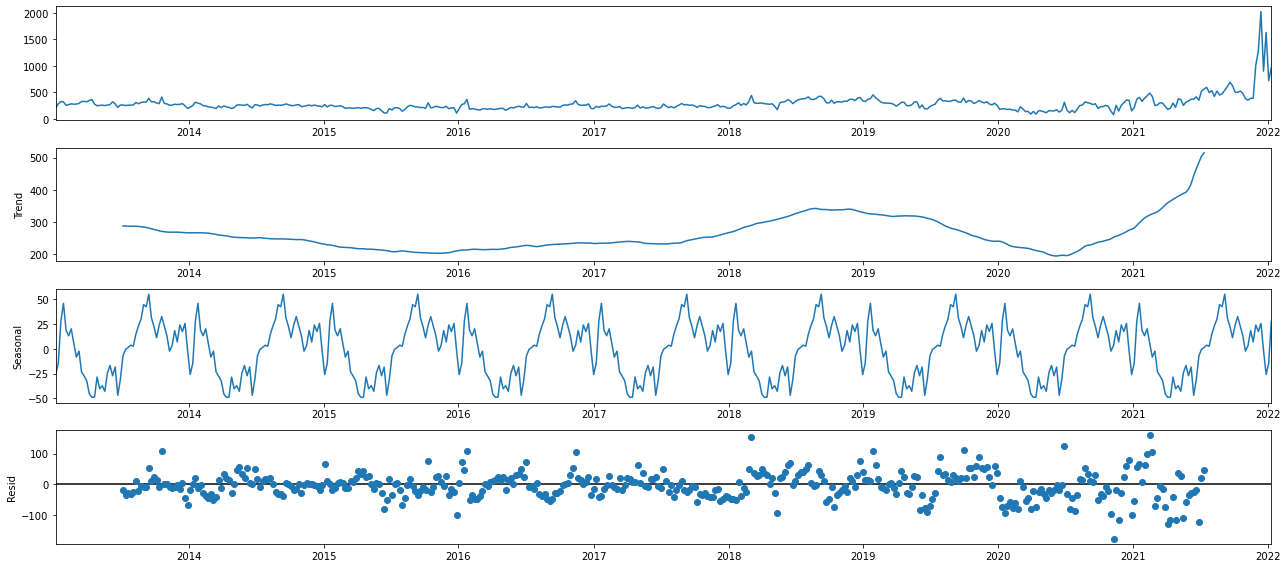

In [4]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive')
fig = decomposition.plot()
plt.show()

## Kausittaisuuden testaus

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

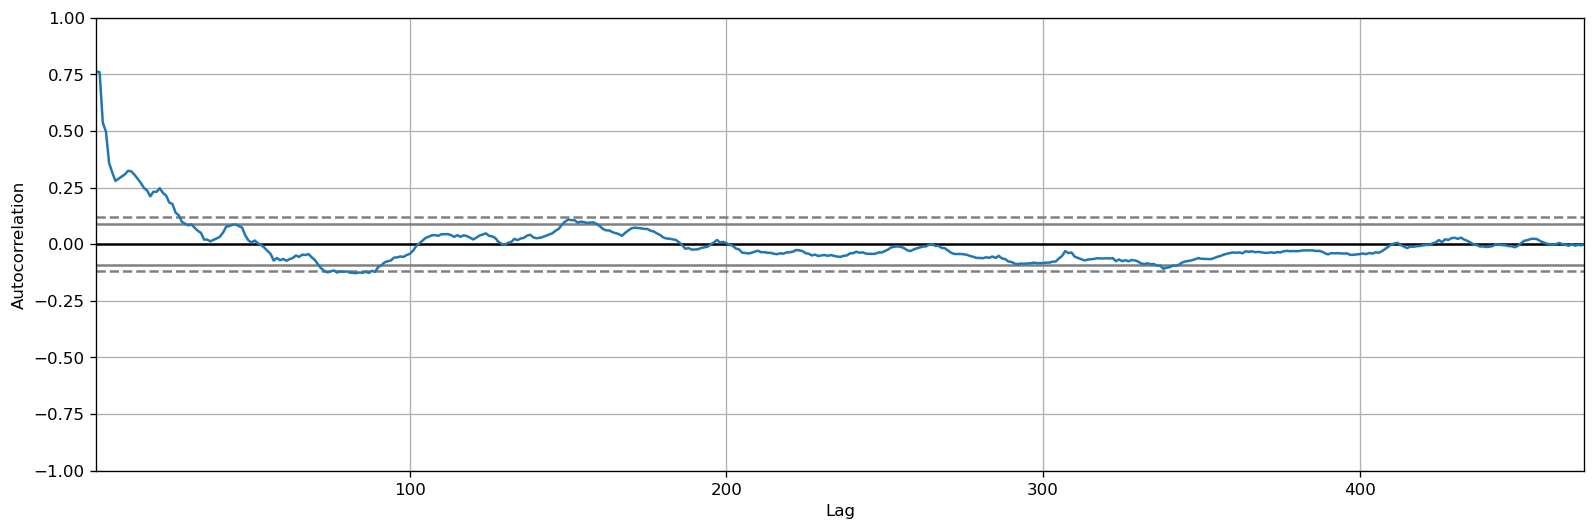

In [5]:

from pandas.plotting import autocorrelation_plot

plt.rcParams.update({'figure.figsize':(16,5), 'figure.dpi':120})
autocorrelation_plot(data.FI.tolist())

## Mallin sovitus

In [6]:
# Ennustemallin sovittaminen (fit()) dataan. 

#Trendiin (trend) käytän summamallia (add), jossa trendi on aikasarjaan lisättävä termi.

#Kausivaihteluun (seasonal) käytän summamallia (add) tai tulomallia (mul). Tässä olen kokeillut myös summamallia, mutta tulomalli osoittautui paremmaksi.

# seasonal_periods-parametrille käytän arvoa 25, koska kausivaihtelu esiintyy noin 25 viikon jaksoissa.

#freq-parametrille käytän arvoa 'W', koska kyseessä on viikkodata. 

# Lisätietoa: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing

malli = ExponentialSmoothing(data['FI'], trend = 'add', seasonal = 'mul', 
                             seasonal_periods = 25, freq='W').fit()

## Simuloidut ennusteet

In [7]:
# simuloidut ennusteet (fittedvalues) jo toteutuneille ajankohdille

data['Ennuste'] = malli.fittedvalues
data

,FI,Ennuste
Date,,
2013-01-06,207.38,372.588905
2013-01-13,284.60,281.223031
2013-01-20,328.39,289.009529
2013-01-27,320.88,317.633849
2013-02-03,258.64,323.615960
...,...,...
2021-12-12,2024.81,1496.115332
2021-12-19,900.95,1127.935082
2021-12-26,1631.22,1386.625979


## Alkuperäinen aikasarja ja mallin mukaiset ennusteet samaan kaavioon

<AxesSubplot:xlabel='Date'>

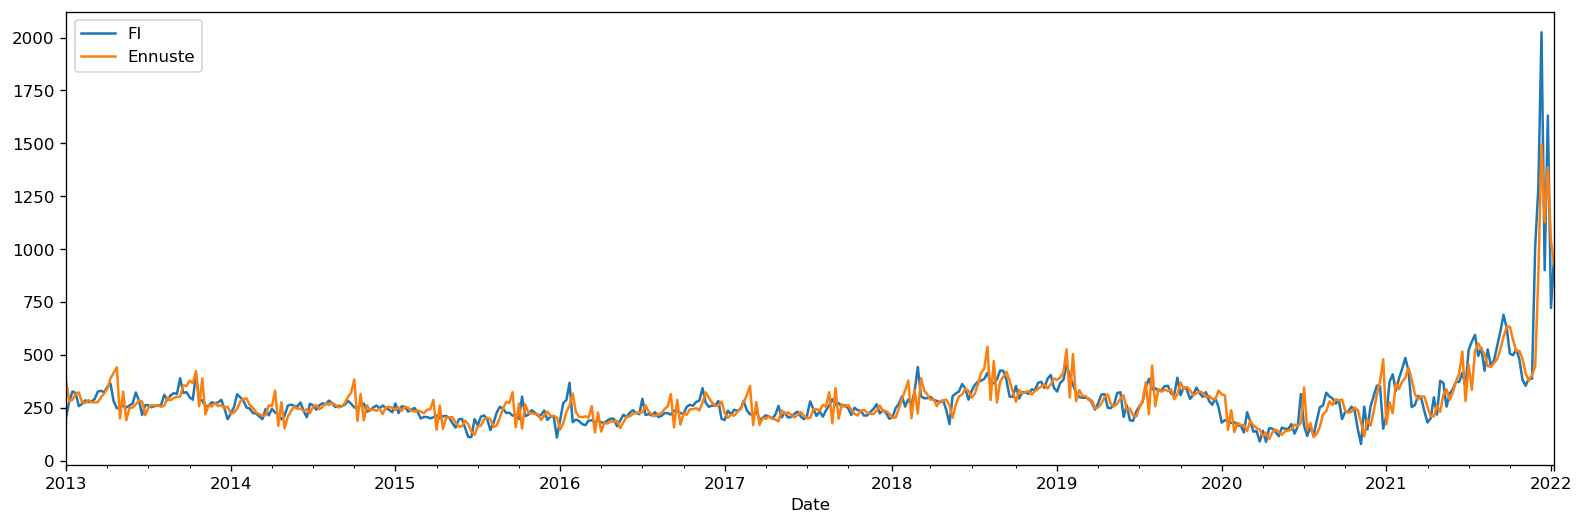

In [8]:
# Alkuperäinen aikasarja ja mallin mukaiset ennusteet samaan kaavioon

data.plot()

## Ennustevirheet

In [9]:
# Ennustevirheet (residuaalit) löytyvät malli-oliosta

data['Ennustevirhe'] = malli.resid
data

,FI,Ennuste,Ennustevirhe
Date,,,
2013-01-06,207.38,372.588905,-165.208905
2013-01-13,284.60,281.223031,3.376969
2013-01-20,328.39,289.009529,39.380471
2013-01-27,320.88,317.633849,3.246151
2013-02-03,258.64,323.615960,-64.975960
...,...,...,...
2021-12-12,2024.81,1496.115332,528.694668
2021-12-19,900.95,1127.935082,-226.985082
2021-12-26,1631.22,1386.625979,244.594021


## Mallin tarkastelu

Text(0, 0.5, 'Ennustevirhe')

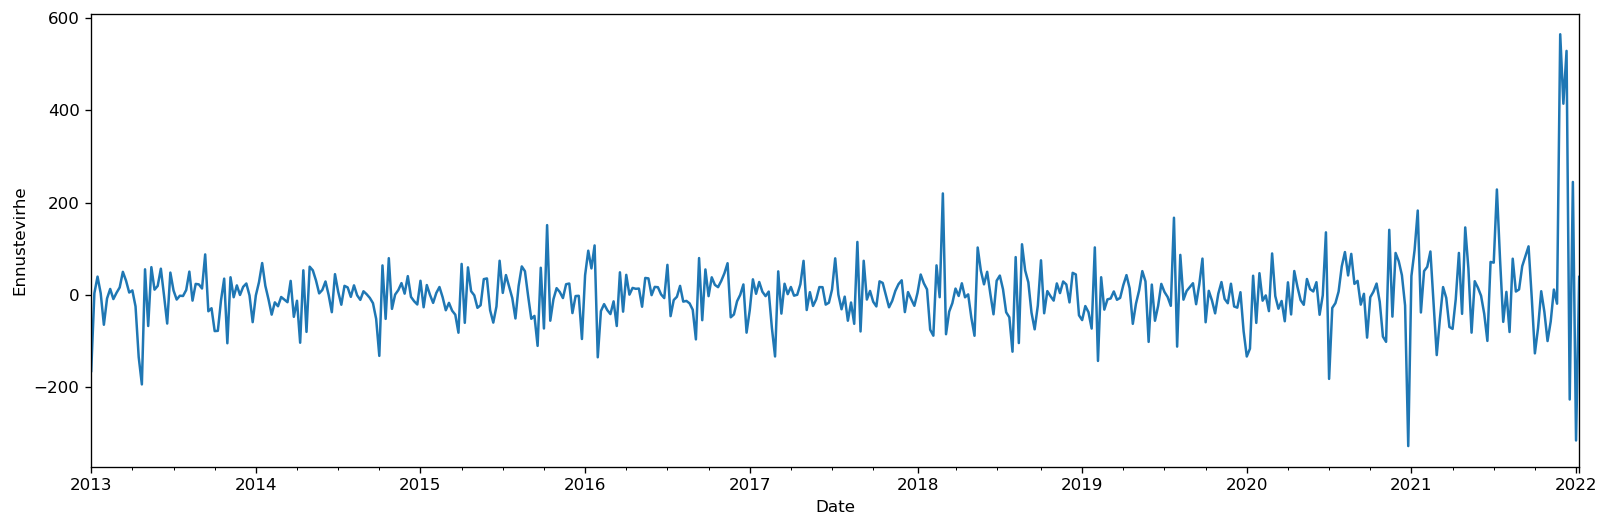

In [10]:
# Mallin hyvyyden tarkasteluun on monia tapoja. 

# Yksi tapa ennustevirheiden aikasarjaa viivakaaviona.

# Toinen tapa ennusteiden ja toteutuneiden arvojen hajontakaaviota, jonka saan summary()-toiminnolla.
# SSE (sum of squared errors). Mallia laskeva algoritmi yrittää saada SSE:n mahdollisimman pieneksi.

# Ennustevirheet aikasarjana, on hyvä, jos ennustevirheiden aikasarjan vaihtelu on sattumanvaraista

data['Ennustevirhe'].plot()
plt.ylabel('Ennustevirhe')

## Mallin hyvyyden arviointi

In [11]:
# Mallin hyvyyden arviointi, miten ennusteet menee keskimäärin väärään suuntaan?

from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Mean squared error', mean_squared_error(data['FI'], data['Ennuste']))
print('Mean absolute error', mean_absolute_error(data['FI'], data['Ennuste']))

Mean squared error 5251.77871081242
Mean absolute error 44.62577591626455


Text(0, 0.5, 'Toteutunut')

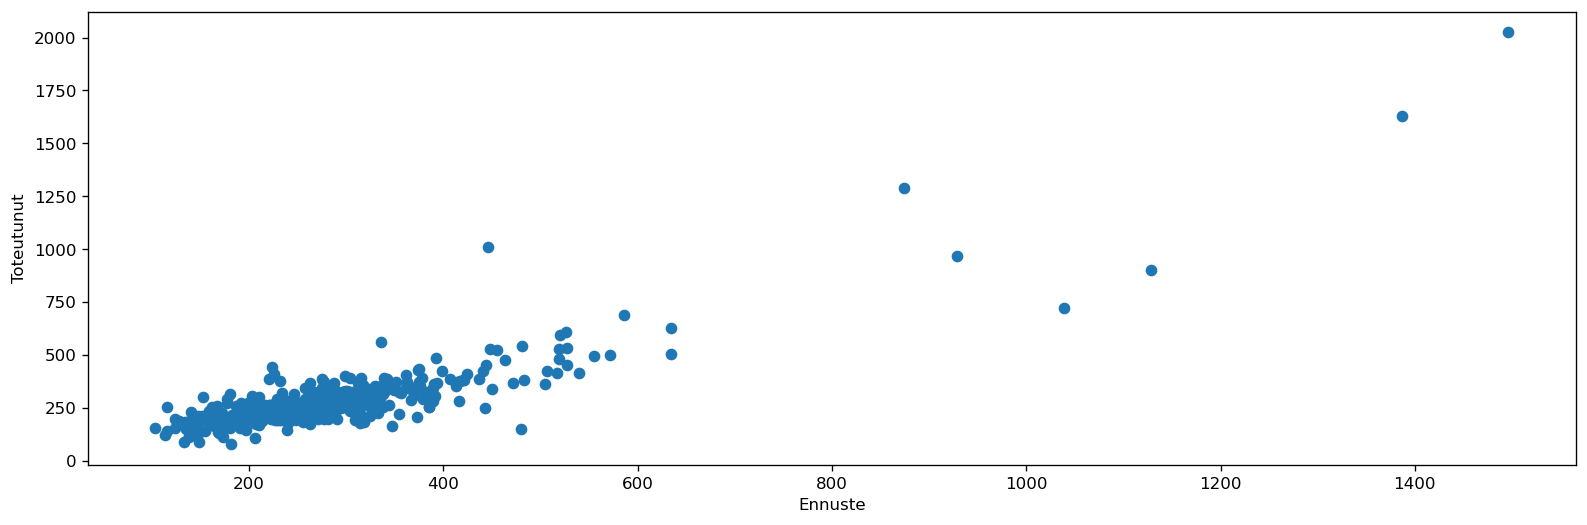

In [12]:
# Ennusteiden ja toteutuneiden kysyntöjen hajontakaavio

# Ennustemalli on sitä parempi, mitä paremmin pisteet seuraavat suoraa viivaa vasemmasta alakulmasta oikeaan yläkulmaan

plt.scatter(x = data['Ennuste'], y = data['FI'])
plt.xlabel('Ennuste')
plt.ylabel('Toteutunut')

In [13]:
# Mallin tiivistelmä

malli.summary()

Dep. Variable:,FI,No. Observations:,471
Model:,ExponentialSmoothing,SSE,2473587.773
Optimized:,True,AIC,4092.738
Trend:,Additive,BIC,4213.229
Seasonal:,Multiplicative,AICC,4097.257
Seasonal Periods:,25,Date:,"Mon, 10 Jan 2022"
Box-Cox:,False,Time:,16:46:16
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6060685,alpha,True
smoothing_trend,0.0001046,beta,True


## Ennusteiden laskeminen

In [14]:
# Ennustettavien ajankohtien aikaleimojen määrittämiseksi.

# Ensimmäisen ennustettavan ajankohdan aikaleiman pitää olla aikasarjan viimeisintä aikaleimaa seuraava aikaleima.

# Ennustettavien ajankohtien lukumäärän voin määrittää periods-parametrilla.

# Ennustettavien ajankohtien frekvenssin on oltava sama kuin mallia sovitettaessa käytetty freq-parametrin arvo.
#L isätietoa:  https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

#Tarkistan viimeisen aikaleiman

data.tail()

,FI,Ennuste,Ennustevirhe
Date,,,
2021-12-12,2024.81,1496.115332,528.694668
2021-12-19,900.95,1127.935082,-226.985082
2021-12-26,1631.22,1386.625979,244.594021
2022-01-02,722.58,1038.404251,-315.824251
2022-01-09,968.03,929.226235,38.803765


In [15]:
# Ennustettavien ajankohtien aikaleimat (alkupäivänä aikasarjan viimeistä aikaleimaa seuraava aikaleima)

index = pd.date_range('2022-01-10', periods = 24, freq = 'W')

# Ennusteet kuudelle viikolle

ennusteet = malli.forecast(24)

# Ennusteet dataframeen

df_ennuste = pd.DataFrame(data = ennusteet, index = index, 
                          columns = ['Ennuste'])
df_ennuste

,Ennuste
2022-01-16,935.563354
2022-01-23,950.482328
2022-01-30,906.817722
2022-02-06,889.979975
2022-02-13,797.724918
2022-02-20,825.059014
2022-02-27,843.570511
2022-03-06,858.082762
2022-03-13,870.548900
2022-03-20,850.551499


<AxesSubplot:xlabel='Date'>

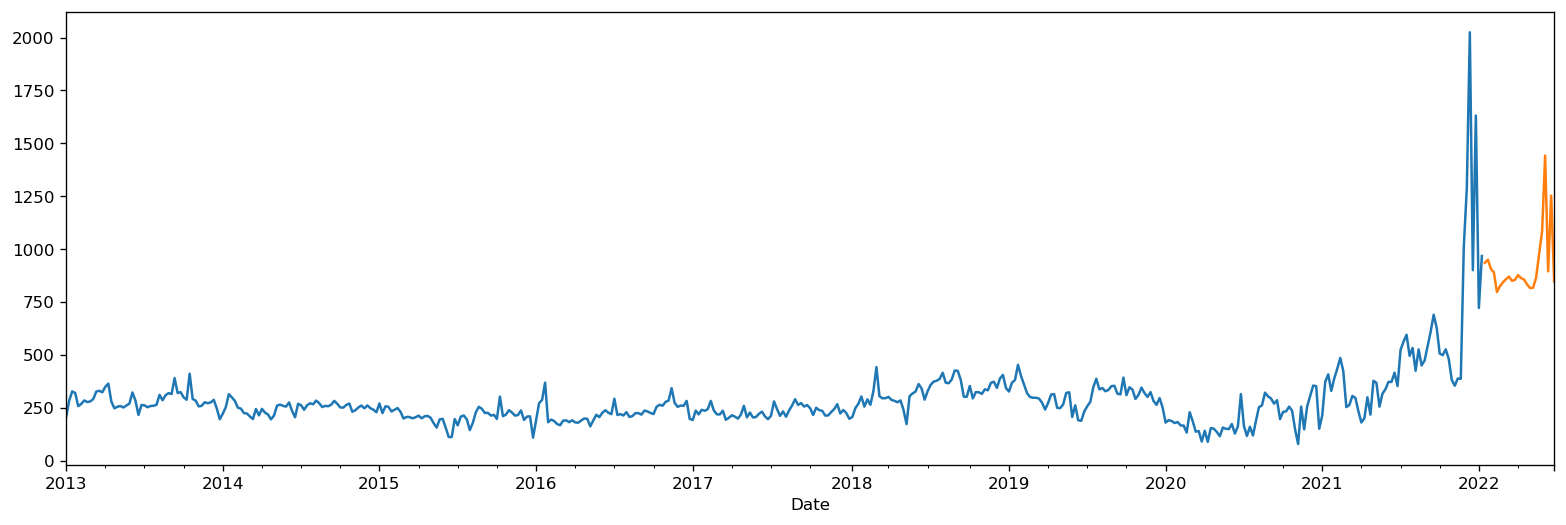

In [16]:
# Viivakaavio havainnoista

data['FI'].plot()

# Ennusteet kaavioon

df_ennuste['Ennuste'].plot()

## Aikasarja, jossa alkuperäinen aikasarja ja lasketut ennusteet

In [17]:
# Dataframe, jossa alkuperäinen aikasarja ja lasketut ennusteet

df1 = pd.concat([data, df_ennuste])
df1

,FI,Ennuste,Ennustevirhe
2013-01-06,207.38,372.588905,-165.208905
2013-01-13,284.60,281.223031,3.376969
2013-01-20,328.39,289.009529,39.380471
2013-01-27,320.88,317.633849,3.246151
2013-02-03,258.64,323.615960,-64.975960
...,...,...,...
2022-05-29,NaN,1085.294334,NaN
2022-06-05,NaN,1442.357587,NaN
2022-06-12,NaN,895.348315,NaN
2022-06-19,NaN,1253.512571,NaN


In [18]:
malli.params

{'smoothing_level': 0.6060685349988001,
 'smoothing_trend': 0.00010460251289572344,
 'smoothing_seasonal': 0.00010359328001374167,
 'damping_trend': nan,
 'initial_level': 287.2167175837497,
 'initial_trend': -0.6496246888004805,
 'initial_seasons': array([1.30018036, 1.34621775, 1.3778012 , 1.40280024, 1.42452066,
        1.39302551, 1.40199904, 1.44001806, 1.41912301, 1.40860882,
        1.37256398, 1.34479671, 1.34819252, 1.42898526, 1.6152105 ,
        1.79497273, 2.38871213, 1.48258176, 2.07946959, 1.40643222,
        1.54566087, 1.5190713 , 1.54489799, 1.47519013, 1.44928938]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

## Visualisaatio keskiarvosta

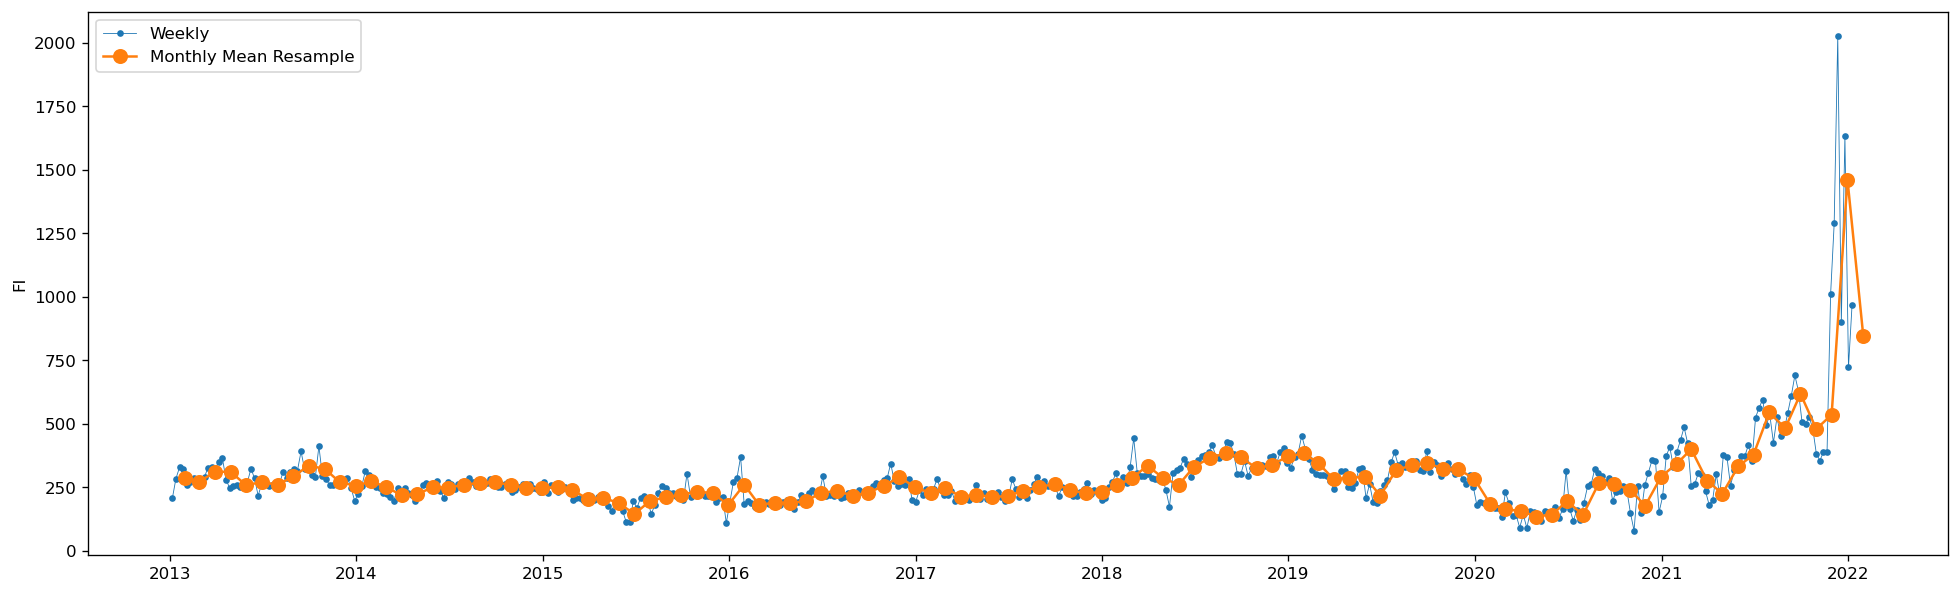

In [19]:
import warnings
import matplotlib.pyplot as plt
y = data['FI']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('FI')
ax.legend();

## Visualisaatio kausittaisuudesta

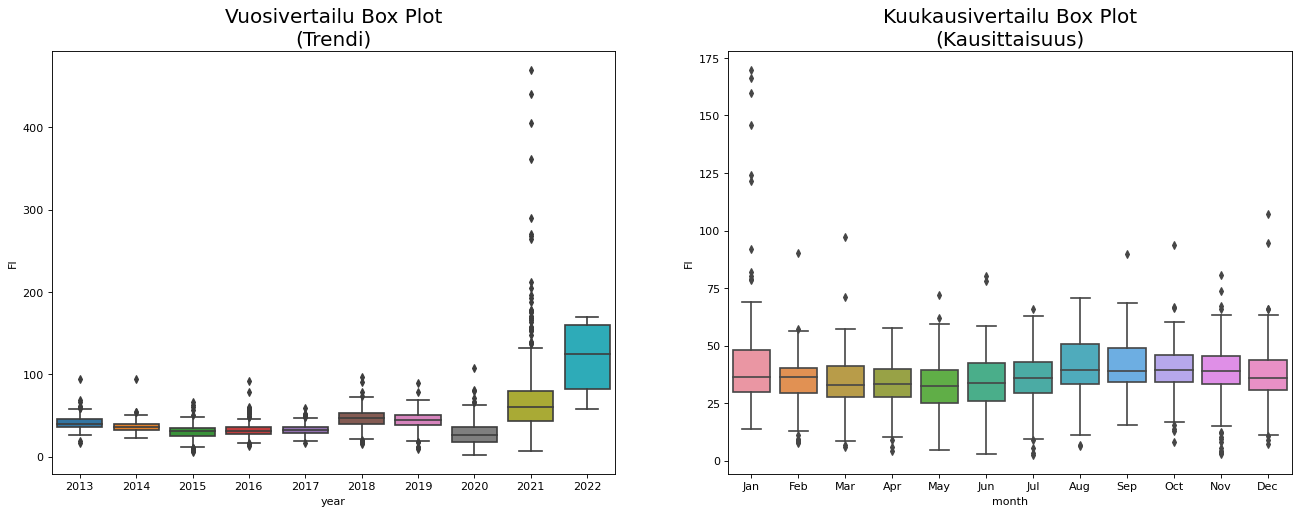

In [20]:
import seaborn as sns
df = pd.read_excel('elspot price 2013 2022.xlsx', index_col='Date')
df.reset_index(inplace=True)

df['year'] = [d.year for d in df.Date]
df['month'] = [d.strftime('%b') for d in df.Date]
years = df['year'].unique()

fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='FI', data=df, ax=axes[0])
sns.boxplot(x='month', y='FI', data=df.loc[~df.year.isin([2017, 2021]), :])

axes[0].set_title('Vuosivertailu Box Plot\n(Trendi)', fontsize=18); 
axes[1].set_title('Kuukausivertailu Box Plot\n(Kausittaisuus)', fontsize=18)
plt.show()